# СОДЕРЖАНИЕ НОУТБУКА

В данном ноутбуке проведены исследования по 3-4 шагам из README:

- === ШАГ 3: Трансляция ===
- === ШАГ 4: Моделирование ===

# === ШАГ 3: Трансляция ===

```
Для решения нашей задачи был выбран следующий подход и метрики:

Оталкиваясь от исследований в этой области было решено строить алгоритм рекомендательной системы банковских продуктов
на основе гибридного подхода, которая сочетает метод коллаборативной фильтрации (ALS) и демографический подход.

Этапы построения алгоритма РС:

   I. Построение ALS-алгоритма: 

    - Построение UI-матрицы «клиенты-продукты» для каждого клиента на основе неявной оценки продукта по определенной шкале в зависимости
от частоты использования этого банковского продукта; 
    - Прогнозирование оценки еще не оцененных продуктов на основе item-based;

   II. Построение алгоритма по демографическому подходу: 

    - Группировка пользователей в кластеры на основе демографических
данных, такие как (возраст, пол, доход, активность, стаж и место жительства) с применением алгоритма k-средних;
    - Построение матрицы «кластеры-продукты», содержащей
среднее значение оценок, присвоенных продукту всеми клиентами в кластере методом динамического взвешивания.

   III. Объединение базовых алгоритмов: 

    - Получение прогнозов по обоим алгоритмам, объединение и сортировка рейтингов в порядке убывания и рекомендация клиенту первых N продуктов.

Разбиение данных:

 - Данные разделяются на обучающий и тестовый набор по глобальному разделению по времени (Global Time Split, Temporal Global). Выбирается одна точка во времени ts: все события до неё входят в тренировочную выборку (прошлое), после неё — в тестовую (будущее). 
 - На основе обучающего набора формируется UI-матрица и матрица «продукты—кластеры».
 - Для формирования тестового набора выбираются клиенты как минимум с тремя продуктами в наборе данных с оценками продуктов.

Метрики:

Выбрана метрика ранжирования NDCG@5, поскольку мы решаем задачу ранжирования и используем алгоритмом ALS. Она принимает значение от 0 (предлагаемый порядок никак не соответствует истинному) до 1 (предлагаемый порядок в точности соответствует истинному). 
```

# === ШАГ 4: Моделирование ===

### 1. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

ASSETS_DIR = "assets"
if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

MODEL_DIR = "models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

### 2. Загрузка очищенных данных
- train_ver2_clean.parquet
- products_catalog.parquet

In [2]:
# Загрузка данных

df = pd.read_parquet(os.path.join(DATA_DIR, "train_ver2_clean.parquet"))
products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

### 3. ALS-модель. Таргет

Для заполнения UI-матрицы необходимо посчитать число неявных оценок клиентов путем группировки и агрегирования транзакционных данных.

In [3]:
# В качестве значений для заполнения UI-матрицы будем использовать отношение длительности владения продуктом к стажу на текущий месяц.

# Посчитаем кол-во месяцев владения клиентом продуктом, т.е. посчитаем кумулятивную сумму, при этом обнуляя счетчик, если продукт был удален.
# Затем нормируем это значение в каждом месяце на текущий стаж клиента.
# Полученное значение будет использовано для заполнения UI-матрицы.
# Его макс значение 1 будет означать максимальную релевантность продукта клиенту, а 0 - нерелевантность.

df = df.sort_values(by=["ncodpers", "fecha_dato"]).reset_index(drop=True)

for colname in products_catalog["names"].to_list():

    df[colname + "_cumsum"] = df.groupby(["ncodpers", df[colname].eq(0).cumsum()])[
        colname
    ].cumsum()
    df[colname + "_cumsum_rank"] = df.groupby("ncodpers")["fecha_dato"].rank()

    df[colname + "_cumsum_ratio"] = round(
        df[colname + "_cumsum"] / df[colname + "_cumsum_rank"],
        2,
    )

In [4]:
# Проверка результатов агрегирования для клиента с ncodpers = 1108076 по продукту "Текущие счета"

ncodpers = 1108076
colname = "ind_cco_fin_ult1"
display(
    df[df["ncodpers"] == ncodpers][
        [
            "fecha_dato",
            "ncodpers",
            colname,
            colname + "_cumsum",
            colname + "_cumsum_rank",
            colname + "_cumsum_ratio",
        ]
    ].sort_values(by="fecha_dato")
)

,fecha_dato,ncodpers,ind_cco_fin_ult1,ind_cco_fin_ult1_cumsum,ind_cco_fin_ult1_cumsum_rank,ind_cco_fin_ult1_cumsum_ratio
7401003,2015-01-28,1108076,1,1,1.0,1.00
7401004,2015-02-28,1108076,1,2,2.0,1.00
7401005,2015-03-28,1108076,1,3,3.0,1.00
7401006,2015-04-28,1108076,1,4,4.0,1.00
7401007,2015-05-28,1108076,1,5,5.0,1.00
7401008,2015-06-28,1108076,1,6,6.0,1.00
7401009,2015-07-28,1108076,1,7,7.0,1.00
7401010,2015-08-28,1108076,0,0,8.0,0.00
7401011,2015-09-28,1108076,1,1,9.0,0.11
7401012,2015-10-28,1108076,1,2,10.0,0.20


In [5]:
# Удаляем лишние столбцы

cumsum_cols = [i + "_cumsum" for i in products_catalog["names"].to_list()]
df = df.drop(columns=cumsum_cols)

cumsum_rank_cols = [i + "_cumsum_rank" for i in products_catalog["names"].to_list()]
df = df.drop(columns=cumsum_rank_cols)

### 4. ALS-модель. Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки по глобальному разделению по времени (Global Time Split, Temporal Global). 

Выбирается одна точка во времени ts: все события до неё входят в тренировочную выборку (прошлое), после неё — в тестовую (будущее).

In [6]:
# Зададим точку разбиения так, чтобы в тест попали данные только за последний месяц

train_test_global_time_split_date = pd.to_datetime("2016-05-28").date()

train_test_global_time_split_idx = df["fecha_dato"].astype("date32[pyarrow]") < train_test_global_time_split_date

events_train = df[train_test_global_time_split_idx].reset_index(drop=True)
print(f"Уникальных пользователей в train: {len(events_train["ncodpers"].drop_duplicates(keep="last"))}")
events_test = df[~train_test_global_time_split_idx].reset_index(drop=True)
print(f"Уникальных пользователей в test: {len(events_test["ncodpers"].drop_duplicates(keep="last"))}")

print(f"Количество взаимодействий в train: {len(events_train)}")
print(f"Количество взаимодействий в test: {len(events_test)}")

Уникальных пользователей в train: 823196
Уникальных пользователей в test: 805434
Количество взаимодействий в train: 10960056
Количество взаимодействий в test: 805434


In [7]:
# Отделим транзакционную часть от персональной

cumsum_ratio_cols = [i + "_cumsum_ratio" for i in products_catalog["names"].to_list()]

events_train_trans = events_train[
    sum(
        [
            ["fecha_dato"],
            ["ncodpers"],
            ["prod_count"],
            products_catalog["names"].to_list(),
            cumsum_ratio_cols,
        ],
        [],
    )
]
events_test_trans = events_test[
    sum(
        [
            ["fecha_dato"],
            ["ncodpers"],
            ["prod_count"],
            products_catalog["names"].to_list(),
            cumsum_ratio_cols,
        ],
        [],
    )
]

events_train_trans

,fecha_dato,ncodpers,prod_count,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1_cumsum_ratio,ind_plan_fin_ult1_cumsum_ratio,ind_pres_fin_ult1_cumsum_ratio,ind_reca_fin_ult1_cumsum_ratio,ind_tjcr_fin_ult1_cumsum_ratio,ind_valo_fin_ult1_cumsum_ratio,ind_viv_fin_ult1_cumsum_ratio,ind_nomina_ult1_cumsum_ratio,ind_nom_pens_ult1_cumsum_ratio,ind_recibo_ult1_cumsum_ratio
0,2015-01-28,15889,4,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2015-02-28,15889,3,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2015-03-28,15889,3,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2015-04-28,15889,3,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2015-05-28,15889,4,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10960051,2016-04-28,1548202,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10960052,2016-04-28,1548203,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10960053,2016-04-28,1548204,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10960054,2016-04-28,1548206,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


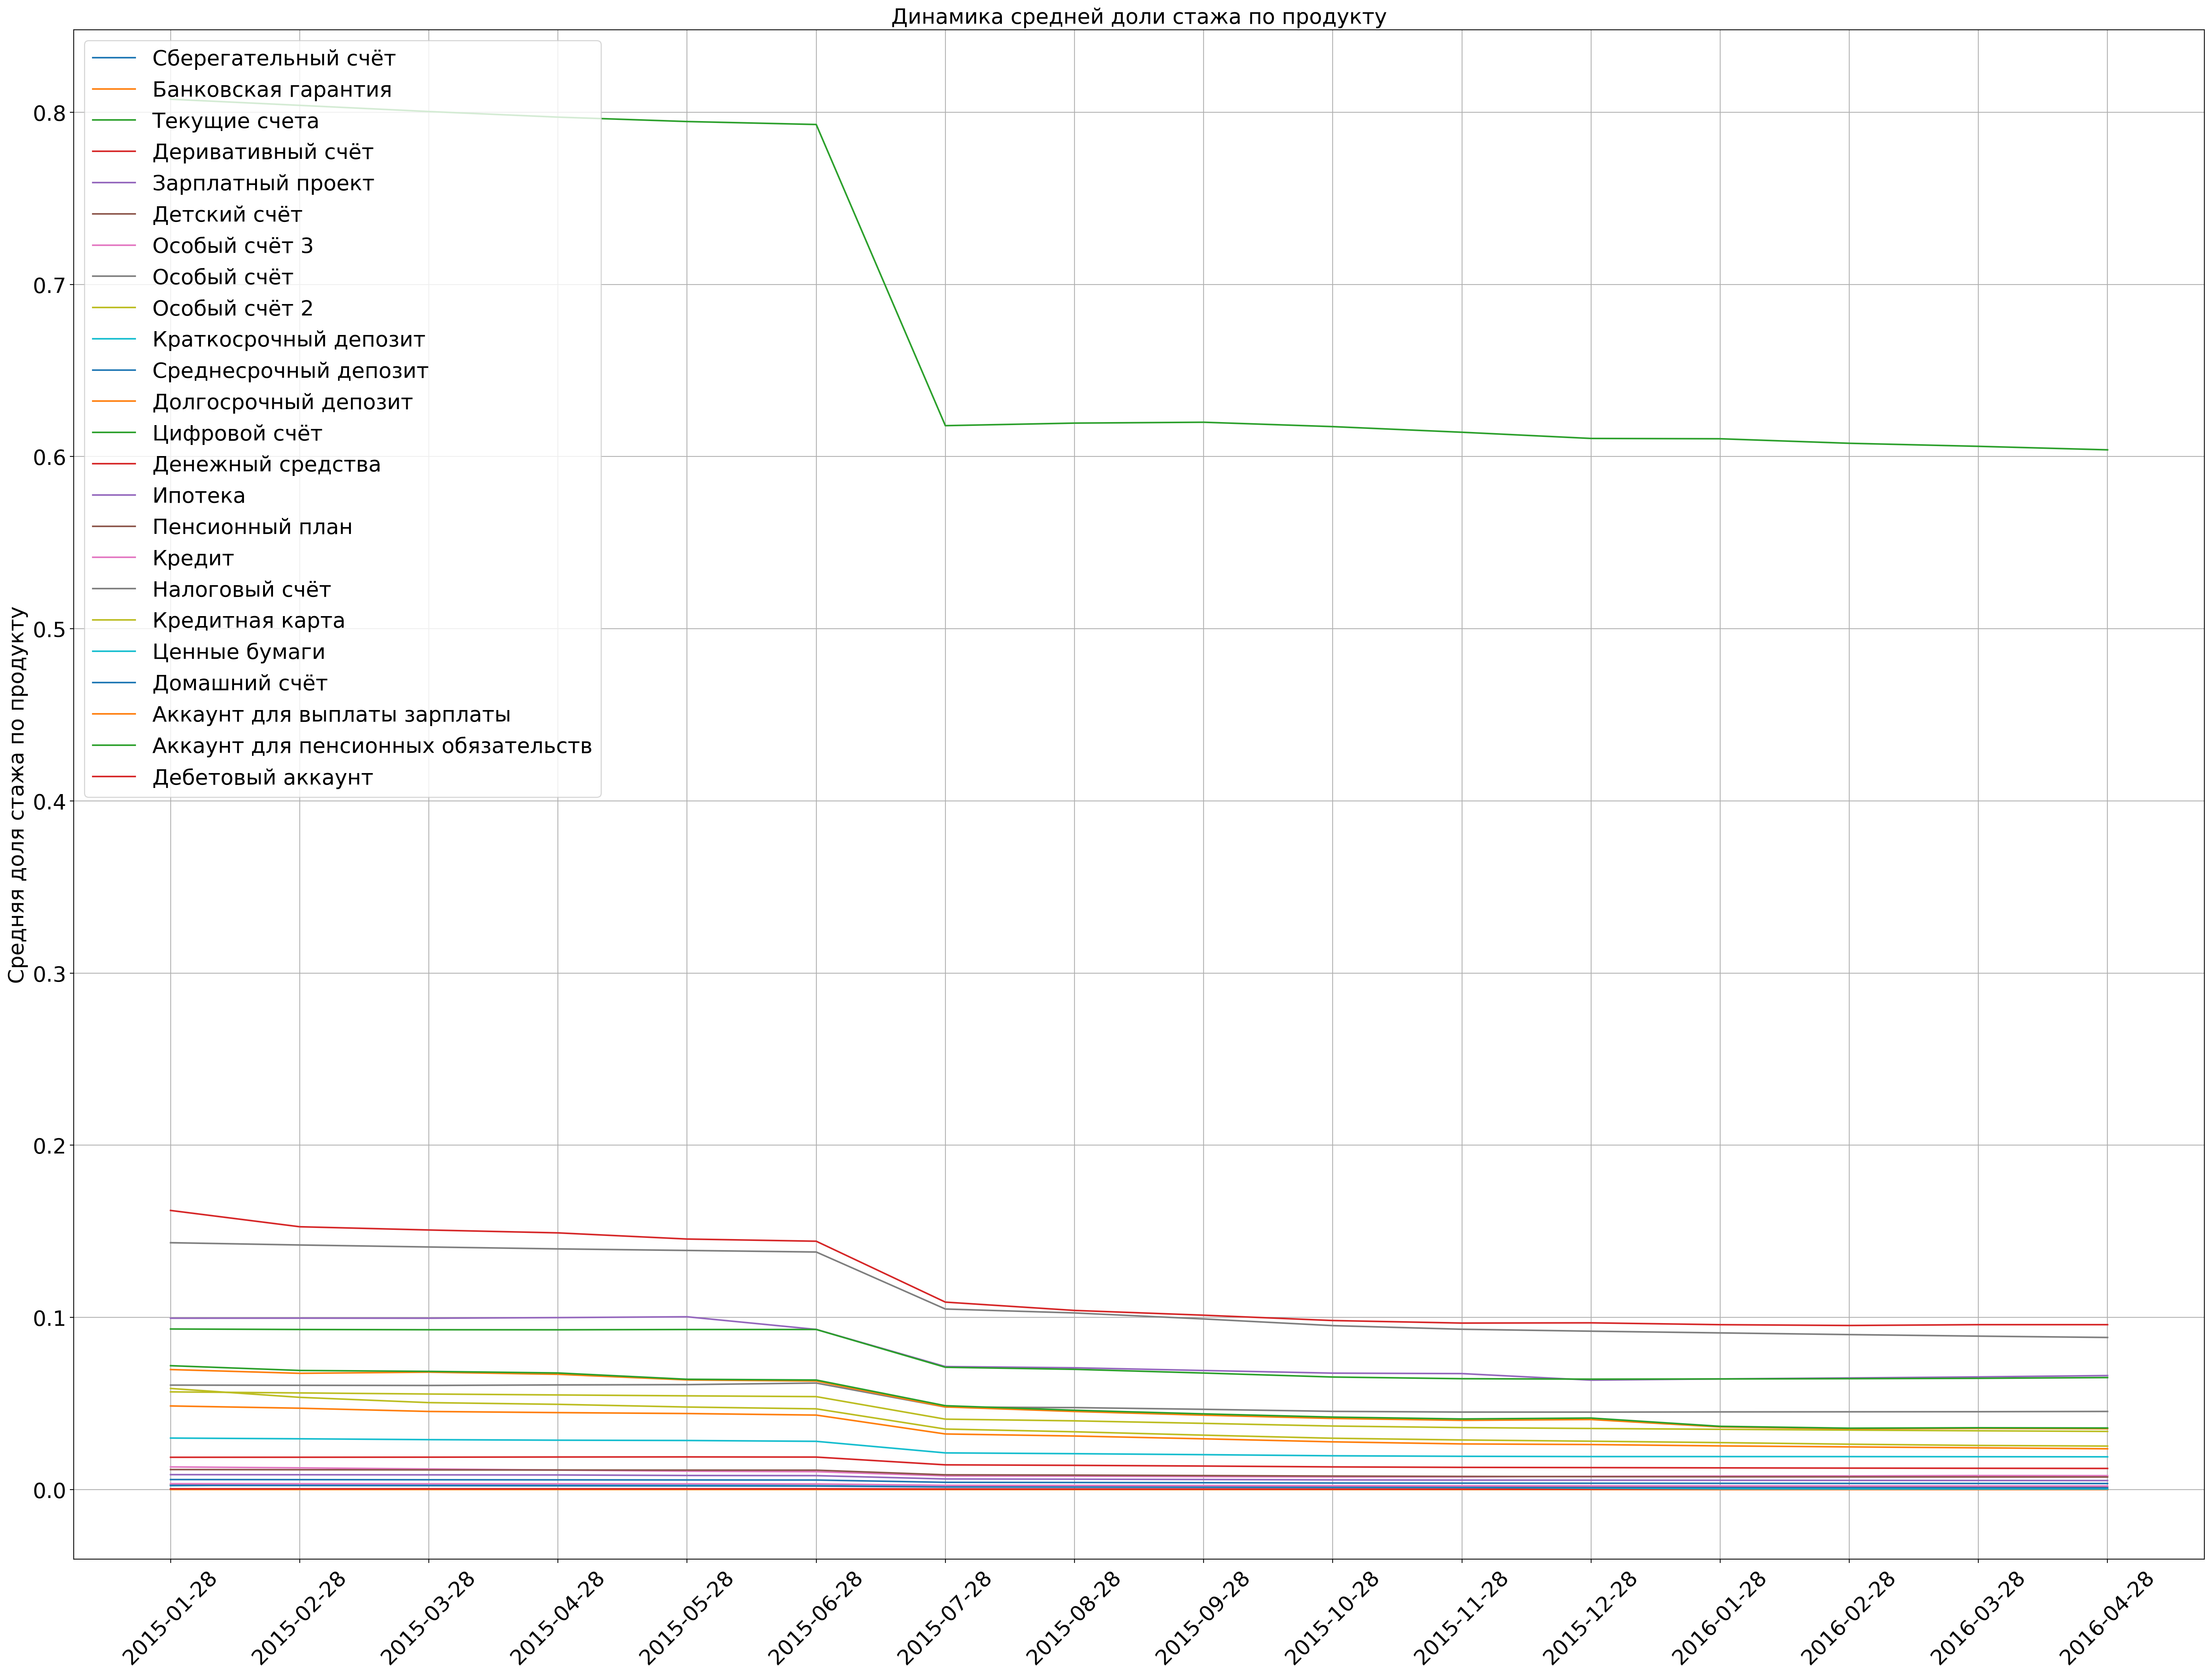

In [8]:
# Визуализируем для наглядности среднюю динамику по *_cumsum_ratio

cumsum_ratio_cols_df = (
    events_train_trans.groupby("fecha_dato")[cumsum_ratio_cols].mean().reset_index()
)

axs = plt.figure(figsize=(36, 26))

for i in cumsum_ratio_cols:
    plt.plot(cumsum_ratio_cols_df["fecha_dato"], cumsum_ratio_cols_df[i])

plt.legend(products_catalog["describe"], loc=2, prop={"size": 20})
plt.tick_params(axis="x", rotation=45, labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.title("Динамика средней доли стажа по продукту", fontsize=20)
plt.ylabel("Средняя доля стажа по продукту", fontsize=20)
plt.grid()
plt.savefig(os.path.join(ASSETS_DIR, "6_cumsum_ratio_dynamic.png"))

In [9]:
# Удалим лишние данные из наборов

# В трейне оставляем данные только последнего месяца
events_train_trans = events_train_trans.drop_duplicates(
    subset="ncodpers", keep="last"
).reset_index()

# В трейне оставляем только тех клиентов, у которых есть хотя бы 1 продукт
events_train_trans = events_train_trans[events_train_trans["prod_count"] >= 1].reset_index()
print(
    f"Уникальных пользователей в train c 1 продуктом и более: {len(events_train_trans)}"
)

# На тесте оставляем только тех клиентов, у которых есть хотя бы 3 продукта
events_test_trans=events_test_trans[events_test_trans["prod_count"]>=3].reset_index()
print(f"Уникальных пользователей в test c 3 продуктами и более: {len(events_test_trans["ncodpers"].drop_duplicates(keep="last"))}")

# На трейне оставляем только идентификаторы клиентов и целевые колонки по продуктам *_cumsum_ratio
events_train_trans = events_train_trans[sum([["ncodpers"], cumsum_ratio_cols], [])]

# Переименуем *_cumsum_ratio в трейне в исходные названия
d={}
prod_names = products_catalog["names"].to_list()
for i,j in enumerate(cumsum_ratio_cols):
    d[j] = prod_names[i]
events_train_trans.rename(columns=d, inplace=True)

# На тесте оставляем только идентификаторы клиентов и целевые колонки по продуктам *_cumsum_ratio
events_test_trans = events_test_trans[sum([["ncodpers"], cumsum_ratio_cols], [])]

# Переименуем *_cumsum_ratio в тесте в исходные названия
events_test_trans.rename(columns=d, inplace=True)

# На тесте оставим только тех пользователей, которые есть в трейне
events_test_trans = events_test_trans[
    events_test_trans["ncodpers"].isin(events_train_trans["ncodpers"])
].reset_index(drop=True)

Уникальных пользователей в train c 1 продуктом и более: 611358
Уникальных пользователей в test c 3 продуктами и более: 105113


In [10]:
# Сохраним на локал промежуточные данные

events_train_trans.to_parquet(os.path.join(DATA_DIR, "events_train_trans.parquet"))
events_test_trans.to_parquet(os.path.join(DATA_DIR, "events_test_trans.parquet"))

### 5. ALS-модель. Обучение

Перед выполнением кода ниже можно почистить kernel

In [1]:
# Импортируем необходимые библиотеки

import numpy as np
import pandas as pd
import os
import sklearn.preprocessing
import scipy
import sys
from implicit.als import AlternatingLeastSquares

ASSETS_DIR = "assets"
DATA_DIR = "data"
MODEL_DIR = "models"

/home/mle-user/anaconda3/lib/python3.12/site-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/home/conda/feedstock_root/build_artifacts/implicit_1724419594932/work/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [2]:
# Загружаем данные

products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

events_train_trans = pd.read_parquet(
    os.path.join(DATA_DIR, "events_train_trans.parquet")
)
events_test_trans = pd.read_parquet(os.path.join(DATA_DIR, "events_test_trans.parquet"))

In [3]:
# Список пользователей из трейна и теста

user_list = list(
    set(
        events_train_trans["ncodpers"].to_list()
        + events_test_trans["ncodpers"].to_list()
    )
)
len(user_list)

611358

In [4]:
# Перекодируем идентификаторы клиентов из имеющихся в последовательность 0, 1, 2, ...

user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(user_list)

events_train_trans["ncodpers_enc"] = user_encoder.transform(
    events_train_trans["ncodpers"]
)

events_test_trans["ncodpers_enc"] = user_encoder.transform(
    events_test_trans["ncodpers"]
)

# В качестве идентификаторов продуктов возьмем индексы из таблицы products_catalog
products_catalog = products_catalog.reset_index().rename(columns={"index": "names_enc"})

In [5]:
# Делаем в качестве индексов - кодированные идентификаторы клиентов, в качестве названий колонок - кодированные идентификаторы продуктов

events_train_trans_matrix = events_train_trans.drop(columns="ncodpers").set_index(
    "ncodpers_enc"
)
events_train_trans_matrix.columns = products_catalog["names_enc"]

events_train_trans_matrix

names_enc,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ncodpers_enc,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0
1,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.00,0.0,1.0,1.0,1.0
2,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0,1.0
3,0.0,0.0,0.45,0.0,0.0,0.0,0.0,0.36,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.18,0.0,0.0,0.0,0.0
4,0.0,0.0,1.00,0.0,0.0,0.0,0.0,1.00,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611353,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
611354,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
611355,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [6]:
# Постром UI-матрицу (sparse-матрицу формата CSR)

user_item_matrix_train = scipy.sparse.csr_matrix(events_train_trans_matrix.values)
print(
    f"Cтепень разреженности UI-матрицы: {(events_train_trans_matrix == 0).sum(axis=1).sum()/(events_train_trans_matrix.shape[0] * events_train_trans_matrix.shape[1])}"
)
print(
    f"Размеры памяти, требуемой для хранения UI-матрицы: {sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3}"
)

Cтепень разреженности UI-матрицы: 0.9267028620437343
Размеры памяти, требуемой для хранения UI-матрицы: 0.03205117583274841


In [7]:
# Обучим ALS-модель. Для бейзлайна возьмём количество латентных факторов для матриц $P, Q$, равным 50.

als_model = AlternatingLeastSquares(
    factors=50, iterations=50, regularization=0.05, random_state=0
)
als_model.fit(user_item_matrix_train)

/home/mle-user/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:


def get_recommendations_als(
    user_item_matrix,
    model,
    user_id,
    user_encoder,
    products_catalog,
    include_seen=True,
    n=5,
):
    """
    Возвращает отранжированные рекомендации для заданного клиента
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n,
    )
    recommendations = pd.DataFrame(
        {"names_enc": recommendations[0], "score": recommendations[1]}
    )
    recommendations = recommendations.merge(
        products_catalog, on="names_enc", how="left"
    )

    return recommendations

In [9]:
# Пример рекомендации для клиента 270434

ncodpers = 270434

recs = get_recommendations_als(
    user_item_matrix_train,
    als_model,
    ncodpers,
    user_encoder,
    products_catalog,
    include_seen=True,
    n=24,
)

recs.head()

,names_enc,score,names,describe
0,2,1.009493,ind_cco_fin_ult1,Текущие счета
1,23,1.003136,ind_recibo_ult1,Дебетовый аккаунт
2,7,0.999536,ind_ctop_fin_ult1,Особый счёт
3,14,0.001048,ind_hip_fin_ult1,Ипотека
4,20,0.000995,ind_viv_fin_ult1,Домашний счёт


In [10]:
# Проверим статус продуктов клиента в трейне и тесте и сравним с рекомендациями

recs.merge(
    events_train_trans_matrix.loc[user_encoder.transform([ncodpers])[0]], on="names_enc"
).merge(
    events_test_trans[events_test_trans["ncodpers"] == ncodpers][
        products_catalog["names"].to_list()
    ].T.reset_index(),
    left_on="names",
    right_on="index",
    how="left",
).drop(
    columns="index"
).set_axis(
    ["names_enc", "als_score", "names", "describe", "train_status", "test_status"],
    axis=1,
).head()

# Т.к. был поставлен флажок include_seen=True, то рекомендации выдаются те, которые были у клиента и в трейне и тесте. Все корректно.

,names_enc,als_score,names,describe,train_status,test_status
0,2,1.009493,ind_cco_fin_ult1,Текущие счета,1.0,1.0
1,23,1.003136,ind_recibo_ult1,Дебетовый аккаунт,1.0,1.0
2,7,0.999536,ind_ctop_fin_ult1,Особый счёт,1.0,1.0
3,14,0.001048,ind_hip_fin_ult1,Ипотека,0.0,0.0
4,20,0.000995,ind_viv_fin_ult1,Домашний счёт,0.0,0.0


In [11]:
# Составим список всех возможных ncodpers (перекодированных)
user_list_encoded = range(len(user_encoder.classes_))

# Получим по 3 рекомендации для всех клиентов, исключая оформленные продукты
als_recommendations = als_model.recommend(
    user_list_encoded,
    user_item_matrix_train[user_list_encoded],
    filter_already_liked_items=True,
    N=3,
)

In [12]:
# Преобразуем полученные рекомендации в табличный формат

names_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame(
    {
        "ncodpers_enc": user_list_encoded,
        "names_enc": names_enc.tolist(),
        "score": als_scores.tolist(),
    }
)

als_recommendations = als_recommendations.explode(
    ["names_enc", "score"], ignore_index=True
)
als_recommendations

,ncodpers_enc,names_enc,score
0,0,7,0.001138
1,0,1,0.000521
2,0,6,0.000458
3,1,4,0.001187
4,1,13,0.000296
...,...,...,...
1834069,611356,22,0.000186
1834070,611356,21,0.000138
1834071,611357,1,0.000952
1834072,611357,23,0.000502


In [13]:
# Приведем типы данных в исходные идентификаторы

als_recommendations["names_enc"] = als_recommendations["names_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["ncodpers"] = user_encoder.inverse_transform(
    als_recommendations["ncodpers_enc"]
)
als_recommendations = als_recommendations.merge(
    products_catalog, on="names_enc", how="left"
)

als_recommendations = als_recommendations.drop(columns=["ncodpers_enc", "names_enc"])
als_recommendations

,score,ncodpers,names,describe
0,0.001138,15889,ind_ctop_fin_ult1,Особый счёт
1,0.000521,15889,ind_aval_fin_ult1,Банковская гарантия
2,0.000458,15889,ind_ctma_fin_ult1,Особый счёт 3
3,0.001187,15894,ind_cno_fin_ult1,Зарплатный проект
4,0.000296,15894,ind_fond_fin_ult1,Денежный средства
...,...,...,...,...
1834069,0.000186,1548133,ind_nom_pens_ult1,Аккаунт для пенсионных обязательств
1834070,0.000138,1548133,ind_nomina_ult1,Аккаунт для выплаты зарплаты
1834071,0.000952,1548142,ind_aval_fin_ult1,Банковская гарантия
1834072,0.000502,1548142,ind_recibo_ult1,Дебетовый аккаунт


In [14]:
# Сохраним на локал промежуточные данные

als_recommendations.to_parquet(os.path.join(DATA_DIR, "personal_als.parquet"))
events_train_trans.to_parquet(os.path.join(DATA_DIR, "events_train_trans.parquet"))
events_test_trans.to_parquet(os.path.join(DATA_DIR, "events_test_trans.parquet"))

als_model.save(os.path.join(MODEL_DIR, "als_model"))

### 6. ALS-модель. Оценка

Перед выполнением кода ниже можно почистить kernel

In [1]:
# Импортируем необходимые библиотеки

import numpy as np
import pandas as pd
import os
import sklearn.preprocessing
import sklearn.metrics
from implicit.als import AlternatingLeastSquares

ASSETS_DIR = "assets"
DATA_DIR = "data"
MODEL_DIR = "models"

/home/mle-user/anaconda3/lib/python3.12/site-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/home/conda/feedstock_root/build_artifacts/implicit_1724419594932/work/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [2]:
# Загружаем данные

products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

events_train_trans = pd.read_parquet(
    os.path.join(DATA_DIR, "events_train_trans.parquet")
)
events_test_trans = pd.read_parquet(os.path.join(DATA_DIR, "events_test_trans.parquet"))

als_recommendations = pd.read_parquet(os.path.join(DATA_DIR, "personal_als.parquet"))

als_model = AlternatingLeastSquares(
    factors=50, iterations=50, regularization=0.05, random_state=0
)
als_model = als_model.load(os.path.join(MODEL_DIR, "als_model.npz"))

/home/mle-user/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


In [3]:
# Переструктурируем обучающий набор и оставим в нем только активные продукты клиента

events_train_trans["score"] = events_train_trans[
    products_catalog["names"].to_list()
].values.tolist()
events_train_trans["names"] = [products_catalog["names"].to_list()] * len(
    events_train_trans
)

events_train_trans = events_train_trans[["ncodpers", "names", "score"]]
events_train_trans = events_train_trans.explode(["score", "names"])
events_train_trans = events_train_trans[events_train_trans["score"] > 0].reset_index(
    drop=True
)
events_train_trans

,ncodpers,names,score
0,15889,ind_cco_fin_ult1,1.0
1,15889,ind_ctpp_fin_ult1,1.0
2,15889,ind_valo_fin_ult1,1.0
3,15894,ind_cco_fin_ult1,1.0
4,15894,ind_ecue_fin_ult1,1.0
...,...,...,...
1075454,1548049,ind_cco_fin_ult1,1.0
1075455,1548125,ind_cco_fin_ult1,1.0
1075456,1548133,ind_cco_fin_ult1,1.0
1075457,1548142,ind_cco_fin_ult1,1.0


In [4]:
# Переструктурируем тестовый набор и оставим в нем только активные продукты клиента

events_test_trans["score"] = events_test_trans[
    products_catalog["names"].to_list()
].values.tolist()
events_test_trans["names"] = [products_catalog["names"].to_list()] * len(
    events_test_trans
)

events_test_trans = events_test_trans[["ncodpers", "names", "score"]]
events_test_trans = events_test_trans.explode(["score", "names"])
events_test_trans = events_test_trans[events_test_trans["score"] > 0].reset_index(
    drop=True
)
events_test_trans

,ncodpers,names,score
0,15889,ind_cco_fin_ult1,1.0
1,15889,ind_ctpp_fin_ult1,1.0
2,15889,ind_tjcr_fin_ult1,0.06
3,15889,ind_valo_fin_ult1,1.0
4,15894,ind_cco_fin_ult1,1.0
...,...,...,...
471409,1547818,ind_nom_pens_ult1,0.5
471410,1547846,ind_cco_fin_ult1,1.0
471411,1547846,ind_nomina_ult1,0.5
471412,1547846,ind_nom_pens_ult1,0.5


In [5]:
# Добавим в датафрейм с рекомендациями истинные оценки из тестовой выборки и обучающей выборки

als_recommendations = als_recommendations.merge(
    events_train_trans[["ncodpers", "names", "score"]].rename(
        columns={"score": "score_train"}
    ),
    on=["ncodpers", "names"],
    how="left",
)

als_recommendations = als_recommendations.merge(
    events_test_trans[["ncodpers", "names", "score"]].rename(
        columns={"score": "score_test"}
    ),
    on=["ncodpers", "names"],
    how="left",
)

als_recommendations

,score,ncodpers,names,describe,score_train,score_test
0,0.001138,15889,ind_ctop_fin_ult1,Особый счёт,NaN,NaN
1,0.000521,15889,ind_aval_fin_ult1,Банковская гарантия,NaN,NaN
2,0.000458,15889,ind_ctma_fin_ult1,Особый счёт 3,NaN,NaN
3,0.001187,15894,ind_cno_fin_ult1,Зарплатный проект,NaN,NaN
4,0.000296,15894,ind_fond_fin_ult1,Денежный средства,NaN,NaN
...,...,...,...,...,...,...
1834069,0.000186,1548133,ind_nom_pens_ult1,Аккаунт для пенсионных обязательств,NaN,NaN
1834070,0.000138,1548133,ind_nomina_ult1,Аккаунт для выплаты зарплаты,NaN,NaN
1834071,0.000952,1548142,ind_aval_fin_ult1,Банковская гарантия,NaN,NaN
1834072,0.000502,1548142,ind_recibo_ult1,Дебетовый аккаунт,NaN,NaN


In [6]:
# Функция подсчета метрики NDCG для одного клиента с помощью sklearn.metrics.ndcg_score


def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )
    return ndcg

In [7]:
# Посчитаем метрику NDCG для k=3 для всех пользователей из тестовой выборки.
# В результате каждому пользователю будет соответствовать одно значение NDCG@3

rating_test_idx = ~als_recommendations["score_test"].isnull()
ndcg_at_3_scores = (
    als_recommendations[rating_test_idx]
    .groupby("ncodpers")
    .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))
)
print(f"NDCG@3 mean: {ndcg_at_3_scores.mean()}")
print(
    f"len(NDCG@3) of notna values]: {len(ndcg_at_3_scores[~ndcg_at_3_scores.isna()])}"
)

NDCG@3 mean: 1.0
len(NDCG@3) of notna values]: 152


/tmp/ipykernel_4484/436360668.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))


In [8]:
# Пример рекомендации для клиента 16056

als_recommendations[als_recommendations["ncodpers"] == 16056]

# Алгоритм выдал в качестве рекомендаций продукты (ind_nom_pens_ult1 и ind_nomina_ult1),
# которых не было в момент обучения (train_score), но они есть на тесте (test_score).
# Т.е. клиент оформил эти продукты в следующем месяце.

,score,ncodpers,names,describe,score_train,score_test
282,0.001322,16056,ind_nom_pens_ult1,Аккаунт для пенсионных обязательств,NaN,0.06
283,0.000755,16056,ind_nomina_ult1,Аккаунт для выплаты зарплаты,NaN,0.06
284,0.000315,16056,ind_pres_fin_ult1,Кредит,NaN,NaN


### 7. ALS-модель. Сохранение результатов

Сохранение таблиц в формат parquet (на локале)

In [9]:
als_recommendations.to_parquet(os.path.join(DATA_DIR, "personal_als.parquet"))

Загрузка в S3

In [10]:
import boto3
from dotenv import load_dotenv

load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

als_recommendations_parquet = os.environ.get("KEY_PERSONAL_ALS_PARQUET")
s3.upload_file(
    os.path.join(DATA_DIR, "personal_als.parquet"),
    BUCKET_NAME,
    als_recommendations_parquet,
)

als_model_npz = os.environ.get("KEY_ALS_MODEL")
s3.upload_file(os.path.join(MODEL_DIR, "als_model.npz"), BUCKET_NAME, als_model_npz)

Логирование артефактов в MLflow

 - sh-скрипт с запуском и настройкой MLflow: run_mlflow_server.sh.
 - запуск: sh run_mlflow_server.sh.
 - переменные окружения загружаются из .env.

In [ ]:
# Команды для запуска логирования

#  !export $(cat .env | xargs)
# !sh run_mlflow_server.sh
# http://127.0.0.1:5000/

In [11]:
import mlflow

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME")

RUN_NAME = "ALS_processing"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact(os.path.join(ASSETS_DIR, "6_cumsum_ratio_dynamic.png"))
    mlflow.log_artifact("recommendations_modeling.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "events_train_trans.parquet"))
    mlflow.log_artifact(os.path.join(DATA_DIR, "events_test_trans.parquet"))
    mlflow.log_artifact(os.path.join(DATA_DIR, "personal_als.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "als_model.npz"))
    mlflow.log_artifact("requirements.txt")

🏃 View run ALS_processing at: http://127.0.0.1:5000/#/experiments/78/runs/f813d1a812784dfca2c3c4126c1813fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/78


### 8. K-MEANS: Алгоритм рекомендаций по демографическому признаку. Загрузка данных

Перед выполнением кода ниже можно почистить kernel

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import sklearn.metrics
import os
import pickle

ASSETS_DIR = "assets"
DATA_DIR = "data"
MODEL_DIR = "models"

In [2]:
# Загружаем данные

df = pd.read_parquet(os.path.join(DATA_DIR, "train_ver2_clean.parquet"))
products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

# Уберем лишние колонки
df = (
    df.drop(columns=["fecha_dato", "prod_count", "ncodpers", "nomprov"])
    .drop_duplicates(keep="last")
    .reset_index(drop=True)
)

# Преобразуем данные
df["ind_actividad_cliente"] = df["ind_actividad_cliente"].apply(lambda x: int(x))
df["ind_nuevo"] = df["ind_nuevo"].apply(lambda x: int(x))
df["age"] = df["age"].apply(lambda x: int(x))
df["cod_prov"] = df["cod_prov"].apply(lambda x: int(x))

print("shape: ", df.shape)

shape:  (7639945, 34)


### 9. K-MEANS. Кодирование признаков

In [3]:
# Создаем трансформеры OneHotEncoder и StandardScaler и кодируем соответствующие колонки

cat_cols = [
    "sexo",
    "ind_nuevo",
    "indext",
    "canal_entrada",
    "cod_prov",
    "ind_actividad_cliente",
    "segmento",
]
num_cols = ["age", "antiguedad", "renta"]

one_hot_drop = OneHotEncoder(drop="if_binary", sparse_output=False)
one_hot_drop.fit(df[cat_cols])

standart_scaler = StandardScaler()
standart_scaler.fit(df[num_cols])


def coding_features(one_hot_drop, standart_scaler, df, cat_cols, num_cols):

    drop_res = one_hot_drop.transform(df[cat_cols])
    scaler_res = standart_scaler.transform(df[num_cols])

    drop_res = pd.DataFrame(drop_res, columns=one_hot_drop.get_feature_names_out())
    scaler_res = pd.DataFrame(scaler_res, columns=num_cols)

    return pd.concat([scaler_res, drop_res], axis=1)

### 10. K-MEANS. Разбиение данных

In [4]:
# Для экономии ресурсов, возьмем в качестве обучающей выборки первые 2 млн данных, а в качестве теста следущие 0.5 млн

train_size = 2000000
test_size = 500000

df_train = df[:train_size]
df_test = df[train_size : train_size + test_size]

del df

drop_res_train = coding_features(
    one_hot_drop, standart_scaler, df_train, cat_cols, num_cols
)
drop_res_train = pd.concat(
    [drop_res_train, df_train[products_catalog["names"].to_list()]], axis=1
)

print("train df shape: ", drop_res_train.shape)

train df shape:  (2000000, 249)


### 11. K-MEANS. Обучение

In [5]:
# Обучим модель кластеризации с дефолтными гиперпараметрами в качестве бейзлайна

kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(
    drop_res_train.drop(columns=products_catalog["names"].to_list())
)
drop_res_train["labels"] = kmeans.predict(
    drop_res_train.drop(columns=products_catalog["names"].to_list())
)

In [6]:
#  Взглянем на данные из одного кластера

drop_res_train[drop_res_train["labels"] == 4]

,age,antiguedad,renta,sexo_V,ind_nuevo_1,indext_S,canal_entrada_004,canal_entrada_007,canal_entrada_013,canal_entrada_K00,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,labels
10,-0.239512,-0.640471,0.069031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4
15,0.097978,-0.640471,-1.127761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,4
16,0.097978,-0.640471,-0.503957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,4
21,0.266723,-0.640471,-0.340769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,4
22,-0.492630,-0.640471,0.308638,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1.279193,-0.809565,-0.113603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,4
1999996,0.182351,-0.809565,-0.635164,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4
1999997,0.688586,-0.809565,-0.650238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,4
1999998,-0.745747,-0.809565,-0.801114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,4


In [7]:
# Группируем по кластерам и осредняем продукты

kmeans_recs = (
    drop_res_train.groupby("labels")[products_catalog["names"].to_list()]
    .mean()
    .reset_index()
)
kmeans_recs

,labels,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0.000000,0.000011,0.560477,0.000212,0.121295,0.001359,0.033591,0.009775,0.068340,...,0.000755,0.003575,0.003855,0.057238,0.053649,0.013598,0.001093,0.084003,0.086704,0.193559
1,1,0.000345,0.000026,0.519548,0.000866,0.178924,0.001203,0.000785,0.308116,0.089899,...,0.031212,0.030222,0.005667,0.124603,0.133994,0.068086,0.012337,0.135478,0.139683,0.256802
2,2,0.000000,0.000000,0.686553,0.000000,0.070831,0.004478,0.006020,0.009257,0.005037,...,0.000050,0.000373,0.000108,0.015148,0.014021,0.004298,0.000043,0.045774,0.047029,0.080841
3,3,0.000422,0.000171,0.549950,0.001247,0.187796,0.002082,0.006206,0.308022,0.118057,...,0.019620,0.033647,0.003159,0.150674,0.143341,0.074663,0.014233,0.143909,0.146499,0.271452
4,4,0.000000,0.000048,0.458799,0.000216,0.134934,0.004618,0.036149,0.010735,0.040740,...,0.000317,0.003702,0.000414,0.057790,0.054811,0.013789,0.001009,0.088994,0.091440,0.220143
5,5,0.000439,0.000122,0.537875,0.000928,0.156888,0.003193,0.016629,0.216397,0.103276,...,0.011284,0.028250,0.002255,0.151042,0.118834,0.070996,0.014028,0.112315,0.114763,0.249462
6,6,0.000000,0.000000,0.802662,0.000006,0.037674,0.000420,0.001708,0.002194,0.001418,...,0.000006,0.000080,0.000073,0.006251,0.004534,0.001127,0.000022,0.023482,0.024187,0.057703
7,7,0.000195,0.000014,0.526992,0.000945,0.111920,0.001377,0.000743,0.287165,0.070239,...,0.012397,0.013868,0.007917,0.089894,0.083988,0.040530,0.009514,0.080698,0.082514,0.170340


In [8]:
# Переструктурируем результаты в виде рекомендаций кластер-продукт

kmeans_recs["score"] = kmeans_recs[products_catalog["names"].to_list()].values.tolist()
kmeans_recs["names"] = [products_catalog["names"].to_list()] * len(kmeans_recs)
kmeans_recs = kmeans_recs[["labels", "names", "score"]]
kmeans_recs = kmeans_recs.explode(["score", "names"])
kmeans_recs = kmeans_recs[kmeans_recs["score"] > 0].reset_index(drop=True)

# Оставим только по 5 первых рекомендаций на каждый кластер

kmeans_recs = (
    kmeans_recs.sort_values(by=["labels", "score"], ascending=[True, False])
    .groupby("labels")
    .head(5)
    .reset_index(drop=True)
)
kmeans_recs

# На первом месте в каждом кластере рекомендуется продукт "Текущие счета".
# Это будет своеобразная ТОП-рекомендация в том случае, если такого продукта у клиента нет, либо для холодных пользователей.

,labels,names,score
0,0,ind_cco_fin_ult1,0.560477
1,0,ind_recibo_ult1,0.193559
2,0,ind_cno_fin_ult1,0.121295
3,0,ind_ecue_fin_ult1,0.116771
4,0,ind_nom_pens_ult1,0.086704
5,1,ind_cco_fin_ult1,0.519548
6,1,ind_ctop_fin_ult1,0.308116
7,1,ind_recibo_ult1,0.256802
8,1,ind_cno_fin_ult1,0.178924
9,1,ind_ecue_fin_ult1,0.152536


### 12. K-MEANS. Оценка

In [9]:
# Предскажем кластеры для тестового набора

drop_res_test = coding_features(
    one_hot_drop, standart_scaler, df_test, cat_cols, num_cols
)
df_test["labels"] = kmeans.predict(drop_res_test)

kmeans_recs_test = (
    df_test.groupby("labels")[products_catalog["names"].to_list()].mean().reset_index()
)
kmeans_recs_test

,labels,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0.000000,0.0,0.618535,0.000093,0.104778,0.000117,0.012860,0.000082,0.000490,...,0.000047,0.001982,0.000082,0.030663,0.022548,0.006960,0.000023,0.073695,0.075677,0.192907
1,1,0.000145,0.0,0.512531,0.001449,0.111111,0.000869,0.000579,0.476894,0.059105,...,0.016515,0.020426,0.003477,0.082863,0.078372,0.043604,0.009271,0.085905,0.088078,0.161959
2,2,0.000000,0.0,0.682474,0.000000,0.044760,0.001437,0.001223,0.000015,0.000015,...,0.000015,0.000092,0.000076,0.007493,0.005138,0.001590,0.000000,0.025905,0.026562,0.052865
3,3,0.000488,0.0,0.555899,0.001302,0.132465,0.002441,0.002278,0.427014,0.071277,...,0.012042,0.024573,0.002441,0.113100,0.097803,0.050610,0.014646,0.102197,0.104312,0.200163
4,4,0.000000,0.0,0.453561,0.000165,0.126404,0.001342,0.003970,0.000037,0.000110,...,0.000129,0.003161,0.000312,0.049977,0.040695,0.010091,0.000018,0.084275,0.086316,0.219961
5,5,0.000252,0.0,0.547084,0.000126,0.098334,0.000757,0.009341,0.100985,0.018051,...,0.003408,0.008457,0.000505,0.074476,0.052512,0.025625,0.003661,0.067786,0.070311,0.195405
6,6,0.000000,0.0,0.804422,0.000008,0.026177,0.000205,0.000322,0.000015,0.000000,...,0.000008,0.000045,0.000057,0.004129,0.002074,0.000591,0.000000,0.014506,0.014995,0.042306
7,7,0.000412,0.0,0.515956,0.000618,0.093473,0.001853,0.000515,0.455631,0.054869,...,0.010603,0.015133,0.003088,0.077620,0.072164,0.036030,0.011015,0.071546,0.072473,0.146901


In [10]:
# Смержим с рекомендациями по трейну

kmeans_recs_test["score_test"] = kmeans_recs_test[
    products_catalog["names"].to_list()
].values.tolist()
kmeans_recs_test["names"] = [products_catalog["names"].to_list()] * len(
    kmeans_recs_test
)
kmeans_recs_test = kmeans_recs_test[["labels", "names", "score_test"]]
kmeans_recs_test = kmeans_recs_test.explode(["score_test", "names"])

kmeans_recs = kmeans_recs.merge(kmeans_recs_test, on=["labels", "names"], how="left")
kmeans_recs

,labels,names,score,score_test
0,0,ind_cco_fin_ult1,0.560477,0.618535
1,0,ind_recibo_ult1,0.193559,0.192907
2,0,ind_cno_fin_ult1,0.121295,0.104778
3,0,ind_ecue_fin_ult1,0.116771,0.091254
4,0,ind_nom_pens_ult1,0.086704,0.075677
5,1,ind_cco_fin_ult1,0.519548,0.512531
6,1,ind_ctop_fin_ult1,0.308116,0.476894
7,1,ind_recibo_ult1,0.256802,0.161959
8,1,ind_cno_fin_ult1,0.178924,0.111111
9,1,ind_ecue_fin_ult1,0.152536,0.119368


In [11]:
# Функция подсчета метрики NDCG для одного клиента с помощью sklearn.metrics.ndcg_score


def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )
    return ndcg

In [12]:
# Посчитаем метрику NDCG для k=5 для всех кластеров из тестовой выборки.
# В результате каждому кластеру будет соответствовать одно значение NDCG@5

rating_test_idx = ~kmeans_recs["score_test"].isnull()
ndcg_at_5_scores = (
    kmeans_recs[rating_test_idx]
    .groupby("labels")
    .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=5))
)
print(ndcg_at_5_scores.mean())
ndcg_at_5_scores.head()

# Получено высокое среднее значение NDCG@5

0.99910702318011


/tmp/ipykernel_3294/3863812115.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = kmeans_recs[rating_test_idx].groupby("labels").apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=5))


labels
0    1.000000
1    0.999634
2    1.000000
3    0.998337
4    1.000000
dtype: float64

### 13. K-MEANS. Сохранение результатов

Сохранение на локале

In [14]:
kmeans_recs.to_parquet(os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"))

# save kmeans
with open(os.path.join(MODEL_DIR, "kmeans_model.pkl"), "wb") as f:
    pickle.dump(kmeans, f)

# save one_hot_drop
with open(os.path.join(MODEL_DIR, "one_hot_drop.pkl"), "wb") as f:
    pickle.dump(one_hot_drop, f)

# save standart_scaler
with open(os.path.join(MODEL_DIR, "standart_scaler.pkl"), "wb") as f:
    pickle.dump(standart_scaler, f)

# with open(os.path.join(MODEL_DIR, "one_hot_drop.pkl", "rb")) as f:
#     one_hot_drop = pickle.load(f)

# with open(os.path.join(MODEL_DIR, "standart_scaler.pkl", "rb")) as f:
#     standart_scaler = pickle.load(f)

Загрузка в S3

In [15]:
import boto3
from dotenv import load_dotenv

load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

kmeans_parquet = os.environ.get("KEY_KMEANS_PARQUET")
s3.upload_file(
    os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"),
    BUCKET_NAME,
    kmeans_parquet,
)

kmeans_model_pkl = os.environ.get("KEY_KMEANS_MODEL")
s3.upload_file(
    os.path.join(MODEL_DIR, "kmeans_model.pkl"), BUCKET_NAME, kmeans_model_pkl
)

kmeans_one_hot_drop_pkl = os.environ.get("KEY_KMEANS_MODEL_ONE_HOT_DROP")
s3.upload_file(
    os.path.join(MODEL_DIR, "one_hot_drop.pkl"), BUCKET_NAME, kmeans_one_hot_drop_pkl
)

kmeans_standart_scaler_pkl = os.environ.get("KEY_KMEANS_MODEL_STANDART_SCALER")
s3.upload_file(
    os.path.join(MODEL_DIR, "standart_scaler.pkl"),
    BUCKET_NAME,
    kmeans_standart_scaler_pkl,
)

Логирование артефактов в MLflow

 - sh-скрипт с запуском и настройкой MLflow: run_mlflow_server.sh.
 - запуск: sh run_mlflow_server.sh.
 - переменные окружения загружаются из .env.

In [ ]:
# Команды для запуска логирования

#  !export $(cat .env | xargs)
# !sh run_mlflow_server.sh
# http://127.0.0.1:5000/

In [5]:
import mlflow

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME")

RUN_NAME = "KMEANS_processing"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("recommendations_modeling.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "kmeans_model.pkl"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "one_hot_drop.pkl"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "standart_scaler.pkl"))
    mlflow.log_artifact("requirements.txt")

TypeError: str expected, not NoneType

### 14. Multi-label classification. Загрузка данных

Перед выполнением кода ниже можно почистить kernel

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import os
from catboost import CatBoostClassifier
import sklearn.metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
)

ASSETS_DIR = "assets"
DATA_DIR = "data"
MODEL_DIR = "models"

In [2]:
# Загружаем данные

df = pd.read_parquet(os.path.join(DATA_DIR, "train_ver2_clean.parquet"))
products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

In [3]:
# Считаем агрегаты

df = df.sort_values(by=["ncodpers", "fecha_dato"]).reset_index(drop=True)

for colname in products_catalog["names"].to_list():

    df[colname + "_cumsum"] = df.groupby(["ncodpers", df[colname].eq(0).cumsum()])[
        colname
    ].cumsum()
    df[colname + "_cumsum_rank"] = df.groupby("ncodpers")["fecha_dato"].rank()

    df[colname + "_cumsum_ratio"] = round(
        df[colname + "_cumsum"] / df[colname + "_cumsum_rank"],
        2,
    )

In [5]:
# Удаляем лишние столбцы
cumsum_cols = [i + "_cumsum" for i in products_catalog["names"].to_list()]
df = df.drop(columns=cumsum_cols)
cumsum_rank_cols = [i + "_cumsum_rank" for i in products_catalog["names"].to_list()]
df = df.drop(columns=cumsum_rank_cols)

# Сортируем обратно по времени
df = df.sort_values(by="fecha_dato").reset_index(drop=True)

# Уберем лишние колонки
df = (
    df.drop(columns=["fecha_dato", "prod_count", "nomprov"])
    .drop_duplicates(keep="last")
    .reset_index(drop=True)
)

# Преобразуем данные
df["ind_actividad_cliente"] = df["ind_actividad_cliente"].apply(lambda x: int(x))
df["ind_nuevo"] = df["ind_nuevo"].apply(lambda x: int(x))
df["age"] = df["age"].apply(lambda x: int(x))
df["cod_prov"] = df["cod_prov"].apply(lambda x: int(x))

print("shape: ", df.shape)

shape:  (8801622, 59)


### 15. Multi-label classification. Разбиение данных

In [3]:
# Для экономии ресурсов первые 2 млн на обучение, следующие 0.5 млн на тест, в качестве таргета - продукты из 24 колонок

cat_cols = [
    "sexo",
    "ind_nuevo",
    "indext",
    "canal_entrada",
    "cod_prov",
    "ind_actividad_cliente",
    "segmento",
]
num_cols = ["age", "antiguedad", "renta"]

cumsum_ratio_cols = [i + "_cumsum_ratio" for i in products_catalog["names"].to_list()]

train_size = 2000000
test_size = 500000

X_train = df[:train_size]
y_train = X_train[products_catalog["names"].to_list()]
X_train_agg = X_train[cumsum_ratio_cols]
X_train_users = X_train["ncodpers"]
X_train = X_train[cat_cols + num_cols]

X_test = df[train_size : train_size + test_size].reset_index(drop=True)
y_test = X_test[products_catalog["names"].to_list()]
X_test_agg = X_test[cumsum_ratio_cols]
X_test_users = X_test["ncodpers"]
X_test = X_test[cat_cols + num_cols]

d = {}
prod_names = products_catalog["names"].to_list()
for i, j in enumerate(cumsum_ratio_cols):
    d[j] = prod_names[i]
X_test_agg.rename(columns=d, inplace=True)

del df

### 16. Multi-label classification. Обучение

In [4]:
# Создаем модель мультилейбл-классификации CatBoostClassifier, указываем категориальные фичи


model = CatBoostClassifier(
    cat_features=cat_cols,
    loss_function="MultiLogloss",
    iterations=10,
    learning_rate=1,
    depth=2,
)

# Обучаем модель
model.fit(X_train, y_train)

# Сохраняем модель
model.save_model(os.path.join(MODEL_DIR, "mlc_model"))

### 17. Multi-label classification. Оценка

In [6]:
# Метрика f1_score и roc_auc_score

y_pred = model.predict(X_test)

print("f1:", f1_score(y_test, np.array(y_pred), average="weighted"))
print("roc_auc:", roc_auc_score(y_test, y_pred, average="weighted"))

# Получены значения метрик:
# f1: 0.48539505957144574
# roc_auc: 0.6252792376610677

f1: 0.48539505957144574
roc_auc: 0.6252792376610677


In [5]:
# Для подсчета метрики NDCG предскажем вероятности продуктов и соберем все в табличный формат

# Рекомендации
y_pred = model.predict_proba(X_test)
mlc_recs = pd.DataFrame(y_pred, columns=products_catalog["names"].to_list())
mlc_recs = pd.concat([X_test_users, mlc_recs], axis=1)
mlc_recs["score"] = mlc_recs[products_catalog["names"].to_list()].values.tolist()
mlc_recs["names"] = [products_catalog["names"].to_list()] * len(mlc_recs)
mlc_recs = mlc_recs[["ncodpers", "names", "score"]]
mlc_recs = mlc_recs.explode(["score", "names"])

# Данные для оценки
y_pred_df_agg = pd.concat([X_test_users, X_test_agg], axis=1)
y_pred_df_agg["score_test"] = y_pred_df_agg[
    products_catalog["names"].to_list()
].values.tolist()
y_pred_df_agg["names"] = [products_catalog["names"].to_list()] * len(y_pred_df_agg)
y_pred_df_agg = y_pred_df_agg[["ncodpers", "names", "score_test"]]
y_pred_df_agg = y_pred_df_agg.explode(["names", "score_test"])

y_pred_df_agg

,ncodpers,names,score_test
0,1102664,ind_ahor_fin_ult1,0.0
0,1102664,ind_aval_fin_ult1,0.0
0,1102664,ind_cco_fin_ult1,1.0
0,1102664,ind_cder_fin_ult1,0.0
0,1102664,ind_cno_fin_ult1,0.0
...,...,...,...
499999,917224,ind_valo_fin_ult1,0.0
499999,917224,ind_viv_fin_ult1,0.0
499999,917224,ind_nomina_ult1,0.0
499999,917224,ind_nom_pens_ult1,0.0


In [6]:
# Оставим только первые ТОП-5 продуктов по агрегатам и смерджим с рекомендациями

y_pred_df_agg = y_pred_df_agg.sort_values(
    by=["ncodpers", "score_test"], ascending=[True, False]
).reset_index(drop=True)
y_pred_df_agg = y_pred_df_agg.groupby("ncodpers").head(5).reset_index(drop=True)

mlc_recs = mlc_recs.merge(y_pred_df_agg, on=["ncodpers", "names"], how="left")
mlc_recs

,ncodpers,names,score,score_test
0,1102664,ind_ahor_fin_ult1,0.000024,0.0
1,1102664,ind_aval_fin_ult1,0.000017,0.0
2,1102664,ind_cco_fin_ult1,0.820593,1.0
3,1102664,ind_cder_fin_ult1,0.000044,0.0
4,1102664,ind_cno_fin_ult1,0.003796,0.0
...,...,...,...,...
11999995,917224,ind_valo_fin_ult1,0.017579,NaN
11999996,917224,ind_viv_fin_ult1,0.002519,NaN
11999997,917224,ind_nomina_ult1,0.157481,NaN
11999998,917224,ind_nom_pens_ult1,0.163242,NaN


In [7]:
# Функция подсчета метрики NDCG для одного клиента с помощью sklearn.metrics.ndcg_score


def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )
    return ndcg

In [8]:
# Посчитаем метрику NDCG для k=3 для всех пользователей из тестовой выборки.
# В результате каждому пользователю будет соответствовать одно значение NDCG@3

rating_test_idx = ~mlc_recs["score_test"].isnull()
ndcg_at_3_scores = (
    mlc_recs[rating_test_idx]
    .groupby("ncodpers")
    .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))
)
print(f"NDCG@3 mean: {ndcg_at_3_scores.mean()}")
print(
    f"len(NDCG@3) of notna values]: {len(ndcg_at_3_scores[~ndcg_at_3_scores.isna()])}"
)

# Получены значения метрики NDCG@3:
# NDCG@3 mean: 0.7421483568020953
# len(NDCG@3) of notna values]: 500000

NDCG@3 mean: 0.7421483568020953
len(NDCG@3) of notna values]: 500000


/tmp/ipykernel_4848/3004387684.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))


### 18. Multi-label classification. Формируем рекомендации

In [22]:
# Предскажем вероятности для трейна+теста
y_pred = model.predict_proba(pd.concat([X_train, X_test], axis=0))
y_pred_users = pd.concat([X_train_users, X_test_users], axis=0)

# Приводим в табличный формат
mlc_recs = pd.DataFrame(y_pred, columns=products_catalog["names"].to_list())
mlc_recs = pd.concat([y_pred_users.reset_index(), mlc_recs], axis=1)
mlc_recs["score"] = mlc_recs[products_catalog["names"].to_list()].values.tolist()
mlc_recs["names"] = [products_catalog["names"].to_list()] * len(mlc_recs)
mlc_recs = mlc_recs[["ncodpers", "names", "score"]]
mlc_recs = mlc_recs.explode(["score", "names"])
mlc_recs = mlc_recs.drop_duplicates(subset=["ncodpers", "names"]).reset_index(drop=True)

# Оставим только первые ТОП-5 рекомендаций для каждого клиента
mlc_recs = mlc_recs.sort_values(
    by=["ncodpers", "score"], ascending=[True, False]
).reset_index(drop=True)
mlc_recs = mlc_recs.groupby("ncodpers").head(5).reset_index(drop=True)

mlc_recs

,ncodpers,names,score
0,15889,ind_ctju_fin_ult1,1.0
1,15889,ind_recibo_ult1,0.589372
2,15889,ind_dela_fin_ult1,0.546281
3,15889,ind_ecue_fin_ult1,0.532874
4,15889,ind_cco_fin_ult1,0.516657
...,...,...,...
3750655,1465759,ind_cco_fin_ult1,0.729518
3750656,1465759,ind_ctju_fin_ult1,0.008519
3750657,1465759,ind_deco_fin_ult1,0.006868
3750658,1465759,ind_recibo_ult1,0.004628


### 19. Multi-label classification. Сохранение результатов

Сохранение на локале

In [23]:
mlc_recs.to_parquet(os.path.join(DATA_DIR, "mlc_recs.parquet"))

# Сохраняем модель
model.save_model(os.path.join(MODEL_DIR, "mlc_model"))

Загрузка в S3

In [24]:
import boto3
from dotenv import load_dotenv

load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

mlc_parquet = os.environ.get("MLC_PARQUET")
s3.upload_file(
    os.path.join(DATA_DIR, "mlc_recs.parquet"),
    BUCKET_NAME,
    mlc_parquet,
)

mlc_model = os.environ.get("MLC_MODEL")
s3.upload_file(os.path.join(MODEL_DIR, "mlc_model"), BUCKET_NAME, mlc_model)

Логирование артефактов в MLflow

 - sh-скрипт с запуском и настройкой MLflow: run_mlflow_server.sh.
 - запуск: sh run_mlflow_server.sh.
 - переменные окружения загружаются из .env.

In [ ]:
# Команды для запуска логирования

#  !export $(cat .env | xargs)
# !sh run_mlflow_server.sh
# http://127.0.0.1:5000/

In [25]:
import mlflow

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = os.getenv("EXPERIMENT_NAME")

RUN_NAME = "MLC_processing"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("recommendations_modeling.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "mlc_recs.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "mlc_model"))
    mlflow.log_artifact("requirements.txt")

🏃 View run MLC_processing at: http://127.0.0.1:5000/#/experiments/78/runs/cf7269584f4149faa2435ef5d927dd03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/78


### 20. Загрузка в S3 вспомогательных данных для работы сервиса

In [19]:
# Сохраним в S3 последний месяц активностей клиентов.
# Он понадобится для сервиса рекомендаций, чтобы учесть наличие продуктов

import boto3
from dotenv import load_dotenv

import pandas as pd
import os

DATA_DIR = "data"

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

load_dotenv()

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)


df = pd.read_parquet(os.path.join(DATA_DIR, "train_ver2_clean.parquet"))
products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

df = (
    df[df["fecha_dato"] == "2016-05-28"]
    .drop(
        columns=[
            "fecha_dato",
            "sexo",
            "ind_nuevo",
            "indext",
            "canal_entrada",
            "cod_prov",
            "ind_actividad_cliente",
            "segmento",
            "age",
            "antiguedad",
            "renta",
            "nomprov",
            "prod_count",
        ]
    )
    .reset_index(drop=True)
)

df["score"] = df[products_catalog["names"].to_list()].values.tolist()
df["names"] = [products_catalog["names"].to_list()] * len(df)
df = df[["ncodpers", "names", "score"]]
df = df.explode(["score", "names"])
df = df.drop_duplicates(subset=["ncodpers", "names"]).reset_index(drop=True)
df = df[df["score"] > 0].reset_index(drop=True)

df.to_parquet(os.path.join(DATA_DIR, "last_activity.parquet"))

last_activity_parquet = os.environ.get("KEY_LAST_ACTIVITY_PARQUET")
s3.upload_file(
    os.path.join(DATA_DIR, "last_activity.parquet"),
    BUCKET_NAME,
    last_activity_parquet,
)

In [2]:
# Сохраним в S3 словарь с тестовым пользователем для удобного тестирования сервиса.

import boto3
from dotenv import load_dotenv
import json
import pandas as pd
import os

DATA_DIR = "data"

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

load_dotenv()

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)


df = pd.read_csv("train_ver2.csv", nrows=2)
ncodpers_dict = df.iloc[0].to_dict()
json.dump(ncodpers_dict, open("service/test_user.json", "w"))

test_user_json = os.environ.get("KEY_TEST_USER_JSON")
s3.upload_file("service/test_user.json", BUCKET_NAME, test_user_json)